In [37]:
def read_binary_with_structure(file_path, x_range=0, y_range=0):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        # print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        if  x_range==0 and y_range==0:
          x_min, x_max = [0,nx]
          y_min, y_max = [0,ny]
        else:    
          x_min, x_max = x_range
          y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)
        nrx1 = np.fromfile(f, dtype=np.float32,count=1)[0]
        nrx2 = np.fromfile(f, dtype=np.float32,count=1)[0]
        nrx3 = np.fromfile(f, dtype=np.float32,count=1)[0]
        nrx4 = np.fromfile(f, dtype=np.float32,count=1)[0]
        nrx5 = np.fromfile(f, dtype=np.float32,count=1)[0]
        jjfine = np.fromfile(f, dtype=np.float32,count=1)[0]
        rtthick = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        xleft = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        xright = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        finemesh = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        y_out = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        rhsp14 = read_2d_array()
        rhsp24 = read_2d_array()
        rhsp34 = read_2d_array()
        x4 = x4-rtthick
        

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        one = np.ones((nx, ny-1), dtype=np.float32)

        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]
        one = one[x_min:x_max+1, y_min:y_max+1]
        rh14 = rh4[x_min:x_max+1, y_min:y_max+1]
        rh24 = rh4[x_min:x_max+1, y_min:y_max+1]
        rh34 = rh4[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "nx": nx,
        "ny": ny,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
        "one": one,
        "nrx1":nrx1,
        "nrx2":nrx2,
        "nrx3":nrx3,
        "nrx4":nrx4,
        "nrx5":nrx5,
        "jjfine":jjfine,
        "rtthick":rtthick,
        "xleft":xleft,
        "xright":xright,
        "finemesh":finemesh,
        "y_out":y_out,
        "rhosp1": rhsp14,
        "rhosp2": rhsp24,
        "rhosp1": rhsp34,
        
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

In [39]:
rtthick

0.0

In [44]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import imageio.v2 as imageio


print("\n\n#################################")
print("#### P4P_images.py ####")
print("#################################\n")


# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "BIN_laser_18"
os.makedirs('./Python/P4P_images/P4P_DenPre_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_IETmp_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_ZiMtl_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
# operation = "test_2"
operation = "actual"
if operation == "test_1":
  l = 1
  file = 0
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  files = sorted([os.path.join(d_name, f) for f in os.listdir(d_name) if f.endswith('.bin')])
  l = len(files)
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


data = read_binary_with_structure(file_path)

nx = data['nx']
ny = data['ny']
x4 = data['x']
y4 = data['y']
u4 = data['u']
all_z = data['zi']
mtl = data['mtl']
rho = data['rho']
nrx1 = data['nrx1']
nrx2 = data['nrx2']
nrx3 = data['nrx3']
nrx4 = data['nrx4']
nrx5 = data['nrx5']
rtthick = data['rtthick']
jjfine = data['jjfine']
xleft = data['xleft']
xright = data['xright']
finemesh = data['finemesh']
y_out = data['y_out']


#grid(m)
grid_x = rtthick/(nrx3-nrx2)
grid_y = finemesh/(jjfine-1)

#密度と電離度の修正値の抽出
Target_all = np.where(mtl == 3)
projectile_all = np.where(mtl == 2)
ambience_all = np.where(mtl == 1)

target_density = rho[0,0]
projectile_density = rho[projectile_all[0][0],0]
print("target_density : {:.2e} [g/cc]".format(target_density))
print("projectile_density : {:.2e} [g/cc]".format(projectile_density))

ambience_init_ion_deg = np.max(all_z[ambience_all])
Target_init_ion_deg = np.max(all_z[Target_all])
projectile_init_ion_deg = np.max(all_z[projectile_all])
print('ambience_initial_ionization_degree:',ambience_init_ion_deg)
print('Target_initial_ionization_degree:',Target_init_ion_deg)
print('projectile_initial_ionization_degree:',projectile_init_ion_deg)

#計算領域の抽出
python_xleft = np.min(x4)*1e6
python_xright = np.max(x4)*1e6
python_y_out = np.max(y4)*1e6
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[um],  xright:",round(python_xright,1),"[um], y_max:",round(python_y_out,1),"[um]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
##描画領域(nm)
x_nm_min = -50
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


print("\n----- start loading -----")
for i in np.arange(0,l,1):

  if operation == "test_1":
    file_path = "./{}/u{:04d}.bin".format(d_name, file)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)

  print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")
    
  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)

  all_z = data['zi']
  mtl = data['mtl']
  all_rho = data['rho']
  Target_solid = np.where((mtl == 2)& (all_rho >= target_density))
  Target_mix = np.where((mtl == 2)& (all_rho < target_density) &(all_rho >= projectile_density))
  Target_plasma = np.where((mtl == 2)& (all_rho < projectile_density))
  projectile_solid = np.where((mtl == 3)&(all_rho >= projectile_density))
  projectile_plasma = np.where((mtl == 3)&(all_rho < projectile_density))
  ambience_all = np.where(mtl == 1)

  all_z[Target_solid] = all_z[Target_solid]- Target_init_ion_deg
  all_z[Target_mix] = all_z[Target_mix]- projectile_init_ion_deg
  all_z[Target_plasma] = all_z[Target_plasma]- ambience_init_ion_deg
  all_z[projectile_solid] = all_z[projectile_solid]- projectile_init_ion_deg
  all_z[projectile_plasma] = all_z[projectile_plasma]- ambience_init_ion_deg
  all_z[ambience_all] = all_z[ambience_all]- ambience_init_ion_deg
  
  # print(data)
  print('-------------------------')
  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')
  # Set up a pylab figure
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax1.set_xlim([python_xleft,python_xright])
  # ax1.set_ylim([-python_y_out,python_y_out])

  # Plot field
  p1=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["P"].flatten()*1e-9,levels=np.linspace(0,250,15))
  p2=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["rho"].flatten(),levels=np.linspace(0,20,21))

  # add color bar
  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx1=divider.append_axes("right", size="5%", pad=0.8)
  cx2=divider.append_axes("left", size="5%", pad=0.8)
  cb3=fig.colorbar(p1,cax=cx1)
  cb3.set_label('Pressure [GPa]')
  cb4=fig.colorbar(p2,cax=cx2)
  cb4.set_label('Density [g/cc]')

  # set labels on left for left side colorbar
  cx2.yaxis.tick_left()
  cx2.yaxis.set_label_position('left')

    # set title
  ax1.set_title('{: 5.2f} us'.format(data["time"]*1e9))

  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_DenPre_{}/P4P_DenPre_{:05d}.png'.format(d_name,i))
    # clear axis for next step
  plt.clf()

  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])

  # Plot field
  p5=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["ti"].flatten(),levels=np.linspace(0,10,21))
  p6=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["te"].flatten(),levels=np.linspace(0,10,21))

  # add color bar
  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx5=divider.append_axes("right", size="5%", pad=0.8)
  cx6=divider.append_axes("left", size="5%", pad=0.8)
  cb7=fig.colorbar(p5,cax=cx5)
  cb7.set_label('Ion energy [eV]')
  cb8=fig.colorbar(p6,cax=cx6)
  cb8.set_label('electron energy [eV]')

  # set labels on left for left side colorbar
  cx6.yaxis.tick_left()
  cx6.yaxis.set_label_position('left')
  # set title
  ax1.set_title('{: 5.2f} ns'.format(data["time"]*1e9))

  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_IETmp_{}/P4P_IETmp_{:05d}.png'.format(d_name,i))
    # clear axis for next step
  plt.clf()

    
  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')    
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])
    
  p7=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,(data["mtl"]-0.1).flatten(),levels=np.linspace(0,3,4))
  p8=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,all_z.flatten(),levels=np.linspace(-1,1,11))

  # add color bar

  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx9=divider.append_axes("right", size="5%", pad=0.8)
  cx10=divider.append_axes("left", size="5%", pad=0.8)
  cb11=fig.colorbar(p7,cax=cx9)
  cb11.set_label('Material')
  cb12=fig.colorbar(p8,cax=cx10)
  cb12.set_label('Ionization degree')
  # set labels on left for left side colorbar
  cx10.yaxis.tick_left()
  cx10.yaxis.set_label_position('left')
  # set title
  ax1.set_title('{: 5.2f} ns'.format(data["time"]*1e9))
      
  # save the figure    
  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_ZiMtl_{}/P4P_ZiMtl_{:05d}.png'.format(d_name,i))
    # clear axis for next step
    plt.clf()

  

if operation == "actual":
    # Directory to save images
    output_dir_1 = './Python/P4P_images/P4P_DenPre_{}/'.format(d_name)
    output_dir_2 = './Python/P4P_images/P4P_IETmp_{}/'.format(d_name)
    output_dir_3 = './Python/P4P_images/P4P_ZiMtl_{}/'.format(d_name)
    output_gif_1 = './Python/P4P_images/P4P_DenPre_{}.gif'.format(d_name)  # Output GIF path
    output_gif_2 = './Python/P4P_images/P4P_IETmp_{}.gif'.format(d_name)  # Output GIF path
    output_gif_3 = './Python/P4P_images/P4P_ZiMtl_{}.gif'.format(d_name)  # Output GIF path
    fps = 60  # 1秒あたりのフレーム数を指定（30FPSなら高速）
    # FPSからフレーム間隔を計算
    frame_duration = 1 / fps
    
  
    image_files_1 = sorted([os.path.join(output_dir_1, f) for f in os.listdir(output_dir_1) if f.endswith('.png')])
    image_files_2 = sorted([os.path.join(output_dir_2, f) for f in os.listdir(output_dir_2) if f.endswith('.png')])
    image_files_3 = sorted([os.path.join(output_dir_3, f) for f in os.listdir(output_dir_3) if f.endswith('.png')])
    
    if len(image_files_1) > 0:
        print(f"Found {len(image_files_1)} images. Creating/updating GIF...")
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files_1]
        imageio.mimsave(output_gif_1, images, duration=frame_duration, loop=0)     
        print("GIF created/updated successfully:", output_gif_1)
        
        print(f"Found {len(image_files_2)} images. Creating/updating GIF...")
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files_2]
        imageio.mimsave(output_gif_2, images, duration=frame_duration, loop=0)     
        print("GIF created/updated successfully:", output_gif_2)
        
        print(f"Found {len(image_files_3)} images. Creating/updating GIF...")
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files_3]
        imageio.mimsave(output_gif_3, images, duration=frame_duration, loop=0)     
        print("GIF created/updated successfully:", output_gif_3)




#################################
#### P4P_images.py ####
#################################

file_number : 302


/tmp/ipykernel_92904/2186676940.py:69: RuntimeWarning: invalid value encountered in scalar divide
  grid_x = rtthick/(nrx3-nrx2)


target_density : 1.67e+01 [g/cc]
projectile_density : 1.00e+00 [g/cc]
ambience_initial_ionization_degree: 0.030200502
Target_initial_ionization_degree: 6.1757
projectile_initial_ionization_degree: 1.2348983
xleft: -54.5 [um],  xright: 262.6 [um], y_max: 297.5 [um]
extract_xleft: -50 [um], extract_xright: 200 [um], extract_y_max: 200 [um]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./BIN_laser_18/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./BIN_laser_18/u0001.bin      time: 0.0 [s]
-------------------------
step: 2      file: ./BIN_laser_18/u0002.bin      time: 5.200791e-11 [s]
-------------------------
step: 3      file: ./BIN_laser_18/u0003.bin      time: 1.01946465e-10 [s]
-------------------------
step: 4      file: ./BIN_laser_18/u0004.bin      time: 1.5464345e-10 [s]
-------------------------
step: 5      file: ./BIN_laser_18/u0005.bin      time: 2.

/tmp/ipykernel_92904/2186676940.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(8,6))


step: 7      file: ./BIN_laser_18/u0007.bin      time: 3.0021108e-10 [s]
-------------------------
step: 8      file: ./BIN_laser_18/u0008.bin      time: 3.509397e-10 [s]
-------------------------
step: 9      file: ./BIN_laser_18/u0009.bin      time: 4.0100873e-10 [s]
-------------------------
step: 10      file: ./BIN_laser_18/u0010.bin      time: 4.5001142e-10 [s]
-------------------------
step: 11      file: ./BIN_laser_18/u0011.bin      time: 5.0069626e-10 [s]
-------------------------
step: 12      file: ./BIN_laser_18/u0012.bin      time: 5.503842e-10 [s]
-------------------------
step: 13      file: ./BIN_laser_18/u0013.bin      time: 6.000151e-10 [s]
-------------------------
step: 14      file: ./BIN_laser_18/u0014.bin      time: 6.502036e-10 [s]
-------------------------
step: 15      file: ./BIN_laser_18/u0015.bin      time: 7.00265e-10 [s]
-------------------------
step: 16      file: ./BIN_laser_18/u0016.bin      time: 7.500997e-10 [s]
-------------------------
step: 17  

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [33]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import imageio.v2 as imageio


print("\n\n#################################")
print("#### P4P_images.py ####")
print("#################################\n")


# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "BIN_laser_900"
os.makedirs('./Python/P4P_images/P4P_DenPre_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_IETmp_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_ZiMtl_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
# operation = "test_2"
operation = "actual"
if operation == "test_1":
  l = 1
  file = 0
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 10
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  files = sorted([os.path.join(d_name, f) for f in os.listdir(d_name) if f.endswith('.bin')])
  l = len(files)
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


data = read_binary_with_structure(file_path)

nx = data['nx']
ny = data['ny']
x4 = data['x']
y4 = data['y']
u4 = data['u']
all_z = data['zi']
mtl = data['mtl']
rho = data['rho']
nrx1 = data['nrx1']
nrx2 = data['nrx2']
nrx3 = data['nrx3']
nrx4 = data['nrx4']
nrx5 = data['nrx5']
rtthick = data['rtthick']
jjfine = data['jjfine']
xleft = data['xleft']
xright = data['xright']
finemesh = data['finemesh']
y_out = data['y_out']
ts = 5.4*1e-9

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jjfine-1)

#密度と電離度の修正値の抽出
Target_all = np.where(mtl == 3)
projectile_all = np.where(mtl == 2)
ambience_all = np.where(mtl == 1)

target_density = rho[0,0]
projectile_density = rho[projectile_all[0][0],0]
print("target_density : {:.2e} [g/cc]".format(target_density))
print("projectile_density : {:.2e} [g/cc]".format(projectile_density))

ambience_init_ion_deg = np.max(all_z[ambience_all])
Target_init_ion_deg = np.max(all_z[Target_all])
projectile_init_ion_deg = np.max(all_z[projectile_all])
print('ambience_initial_ionization_degree:',ambience_init_ion_deg)
print('Target_initial_ionization_degree:',Target_init_ion_deg)
print('projectile_initial_ionization_degree:',projectile_init_ion_deg)

#計算領域の抽出
python_xleft = np.min(x4)*1e6
python_xright = np.max(x4)*1e6
python_y_out = np.max(y4)*1e6
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[um],  xright:",round(python_xright,1),"[um], y_max:",round(python_y_out,1),"[um]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
##描画領域(nm)
x_nm_min = -50
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


print("\n----- start loading -----")
for i in np.arange(0,l,1):

  if operation == "test_1":
    file_path = "./{}/u{:04d}.bin".format(d_name, file)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)

  print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")
    
  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)

  all_z = data['zi']
  mtl = data['mtl']
  all_rho = data['rho']
  Target_solid = np.where((mtl == 2)& (all_rho >= target_density))
  Target_mix = np.where((mtl == 2)& (all_rho < target_density) &(all_rho >= projectile_density))
  Target_plasma = np.where((mtl == 2)& (all_rho < projectile_density))
  projectile_solid = np.where((mtl == 3)&(all_rho >= projectile_density))
  projectile_plasma = np.where((mtl == 3)&(all_rho < projectile_density))
  ambience_all = np.where(mtl == 1)

  all_z[Target_solid] = all_z[Target_solid]- Target_init_ion_deg
  all_z[Target_mix] = all_z[Target_mix]- projectile_init_ion_deg
  all_z[Target_plasma] = all_z[Target_plasma]- ambience_init_ion_deg
  all_z[projectile_solid] = all_z[projectile_solid]- projectile_init_ion_deg
  all_z[projectile_plasma] = all_z[projectile_plasma]- ambience_init_ion_deg
  all_z[ambience_all] = all_z[ambience_all]- ambience_init_ion_deg
  
  # print(data)
  print('-------------------------')
  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')
  # Set up a pylab figure
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax1.set_xlim([python_xleft,python_xright])
  # ax1.set_ylim([-python_y_out,python_y_out])

  # Plot field
  p1=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["P"].flatten()*1e-9,levels=np.linspace(0,225,11))
  p2=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["rho"].flatten(),levels=np.linspace(0,20,21))

  # add color bar
  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx1=divider.append_axes("right", size="5%", pad=0.8)
  cx2=divider.append_axes("left", size="5%", pad=0.8)
  cb3=fig.colorbar(p1,cax=cx1)
  cb3.set_label('Pressure [GPa]')
  cb4=fig.colorbar(p2,cax=cx2)
  cb4.set_label('Density [g/cc]')

  # set labels on left for left side colorbar
  cx2.yaxis.tick_left()
  cx2.yaxis.set_label_position('left')

    # set title
  ax1.set_title('{: 5.2f} us'.format(data["time"]*1e9))

  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_DenPre_{}/P4P_DenPre_{:05d}.png'.format(d_name,i))
    # clear axis for next step
  plt.clf()

  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])

  # Plot field
  p5=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["ti"].flatten(),levels=np.linspace(0,10,21))
  p6=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["te"].flatten(),levels=np.linspace(0,10,21))

  # add color bar
  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx5=divider.append_axes("right", size="5%", pad=0.8)
  cx6=divider.append_axes("left", size="5%", pad=0.8)
  cb7=fig.colorbar(p5,cax=cx5)
  cb7.set_label('Ion energy [eV]')
  cb8=fig.colorbar(p6,cax=cx6)
  cb8.set_label('electron energy [eV]')

  # set labels on left for left side colorbar
  cx6.yaxis.tick_left()
  cx6.yaxis.set_label_position('left')
  # set title
  ax1.set_title('{: 5.2f} ns'.format(data["time"]*1e9))

  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_IETmp_{}/P4P_IETmp_{:05d}.png'.format(d_name,i))
    # clear axis for next step
  plt.clf()

    
  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')    
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])
    
  p7=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,(data["mtl"]-0.1).flatten(),levels=np.linspace(0,3,4))
  p8=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,all_z.flatten(),levels=np.linspace(-1,1,11))

  # add color bar

  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx9=divider.append_axes("right", size="5%", pad=0.8)
  cx10=divider.append_axes("left", size="5%", pad=0.8)
  cb11=fig.colorbar(p7,cax=cx9)
  cb11.set_label('Material')
  cb12=fig.colorbar(p8,cax=cx10)
  cb12.set_label('Ionization degree')
  # set labels on left for left side colorbar
  cx10.yaxis.tick_left()
  cx10.yaxis.set_label_position('left')
  # set title
  ax1.set_title('{: 5.2f} ns'.format(data["time"]*1e9))
      
  # save the figure    
  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_ZiMtl_{}/P4P_ZiMtl_{:05d}.png'.format(d_name,i))
    # clear axis for next step
    plt.clf()

  

if operation == "actual":
    # Directory to save images
    output_dir_1 = './Python/P4P_images/P4P_DenPre_{}/'.format(d_name)
    output_dir_2 = './Python/P4P_images/P4P_IETmp_{}/'.format(d_name)
    output_dir_3 = './Python/P4P_images/P4P_ZiMtl_{}/'.format(d_name)
    output_gif_1 = './Python/P4P_images/P4P_DenPre_{}.gif'.format(d_name)  # Output GIF path
    output_gif_2 = './Python/P4P_images/P4P_IETmp_{}.gif'.format(d_name)  # Output GIF path
    output_gif_3 = './Python/P4P_images/P4P_ZiMtl_{}.gif'.format(d_name)  # Output GIF path
    fps = 60  # 1秒あたりのフレーム数を指定（30FPSなら高速）
    # FPSからフレーム間隔を計算
    frame_duration = 1 / fps
    
  
    image_files_1 = sorted([os.path.join(output_dir_1, f) for f in os.listdir(output_dir_1) if f.endswith('.png')])
    image_files_2 = sorted([os.path.join(output_dir_2, f) for f in os.listdir(output_dir_2) if f.endswith('.png')])
    image_files_3 = sorted([os.path.join(output_dir_3, f) for f in os.listdir(output_dir_3) if f.endswith('.png')])
    
    if len(image_files_1) > 0:
        print(f"Found {len(image_files_1)} images. Creating/updating GIF...")
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files_1]
        imageio.mimsave(output_gif_1, images, duration=frame_duration, loop=0)     
        print("GIF created/updated successfully:", output_gif_1)
        
        print(f"Found {len(image_files_2)} images. Creating/updating GIF...")
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files_2]
        imageio.mimsave(output_gif_2, images, duration=frame_duration, loop=0)     
        print("GIF created/updated successfully:", output_gif_2)
        
        print(f"Found {len(image_files_3)} images. Creating/updating GIF...")
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files_3]
        imageio.mimsave(output_gif_3, images, duration=frame_duration, loop=0)     
        print("GIF created/updated successfully:", output_gif_3)




#################################
#### P4P_images.py ####
#################################

file_number : 302
target_density : 1.67e+01 [g/cc]
projectile_density : 1.00e+00 [g/cc]
ambience_initial_ionization_degree: 0.030200502
Target_initial_ionization_degree: 6.1757
projectile_initial_ionization_degree: 1.2348983
xleft: -54.6 [um],  xright: 262.5 [um], y_max: 297.5 [um]
extract_xleft: -50 [um], extract_xright: 200 [um], extract_y_max: 200 [um]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./BIN_laser_900/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./BIN_laser_900/u0001.bin      time: 0.0 [s]
-------------------------
step: 2      file: ./BIN_laser_900/u0002.bin      time: 5.0489682e-11 [s]
-------------------------
step: 3      file: ./BIN_laser_900/u0003.bin      time: 1.00462666e-10 [s]
-------------------------
step: 4      file: ./BIN_laser_900/u00

/tmp/ipykernel_92904/4155305331.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(8,6))


step: 7      file: ./BIN_laser_900/u0007.bin      time: 3.0013728e-10 [s]
-------------------------
step: 8      file: ./BIN_laser_900/u0008.bin      time: 3.5004044e-10 [s]
-------------------------
step: 9      file: ./BIN_laser_900/u0009.bin      time: 4.0010473e-10 [s]
-------------------------
step: 10      file: ./BIN_laser_900/u0010.bin      time: 4.501645e-10 [s]
-------------------------
step: 11      file: ./BIN_laser_900/u0011.bin      time: 5.000179e-10 [s]
-------------------------
step: 12      file: ./BIN_laser_900/u0012.bin      time: 5.5019395e-10 [s]
-------------------------
step: 13      file: ./BIN_laser_900/u0013.bin      time: 6.000114e-10 [s]
-------------------------
step: 14      file: ./BIN_laser_900/u0014.bin      time: 6.500769e-10 [s]
-------------------------
step: 15      file: ./BIN_laser_900/u0015.bin      time: 7.0020756e-10 [s]
-------------------------
step: 16      file: ./BIN_laser_900/u0016.bin      time: 7.50085e-10 [s]
-------------------------

NameError: name 'image_files' is not defined

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [45]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


print("\n\n############################")
print("#### P4P_charge+plot.py ####")
print("############################\n")


d_names = ["B20","BIN_laser_54","B8","BIN_laser_135","B12","BIN_laser_270"]

for k in range(0,len(d_names),1):
    d_name = d_names[k]
    # os.makedirs('./Python/P4P_charge/'.format(d_name), exist_ok=True)

    #テスト/本番設定
    # operation = "test_1"
    # operation = "test_2"
    operation = "actual"
    if operation == "test_1":
      l = 1
      file = 20
      file_path = "./{}/u0000.bin".format(d_name)
    if operation == "test_2":
      l = 25
      file_path = "./{}/u0000.bin".format(d_name)
    if operation == "actual":
      # l = 100
      files = sorted([os.path.join(d_name, f) for f in os.listdir(d_name) if f.endswith('.bin')])
      l = len(files)
      file_path = "./{}/u0000.bin".format(d_name)
    
    print("d_name : ",d_name,"     file_number :",l)
    
    
    data = read_binary_with_structure(file_path)
    
    nx = data['nx']
    ny = data['ny']
    x4 = data['x']
    y4 = data['y']
    u4 = data['u']
    all_z = data['zi']
    mtl = data['mtl']
    rho = data['rho']
    # nrx1 = data['nrx1']
    # nrx2 = data['nrx2']
    # nrx3 = data['nrx3']
    # nrx4 = data['nrx4']
    # nrx5 = data['nrx5']
    # rtthick = data['rtthick']
    # jjfine = data['jjfine']
    # xleft = data['xleft']
    # xright = data['xright']
    # finemesh = data['finemesh']
    # y_out = data['y_out']

        #パラメータ(cell)
    nxr1=50
    nxr2=150
    nxr3=250
    nxr4=300
    nxr5=nx
    ny=451
    nx=1251
    jj2=201
    
    #パラメータ(cm to m)
    rtthick = 25e-4*1e-2
    xleft = 30e-4*1e-2
    xright = 230e-4*1e-2
    finemesh = 100e-4*1e-2
    y_out = 200e-4*1e-2
    
    #grid(m)
    grid_x = rtthick/(nxr3-nxr2)
    grid_y = finemesh/(jj2-1)
    
    ts=5.4*1e-9

    
    #密度と電離度の修正値の抽出
    Target_all = np.where(mtl == 3)
    projectile_all = np.where(mtl == 2)
    ambience_all = np.where(mtl == 1)
    
    target_density = rho[0,0]
    projectile_density = rho[projectile_all[0][0],0]
    print("target_density : {:.2e} [g/cc]".format(target_density))
    print("projectile_density : {:.2e} [g/cc]".format(projectile_density))
    
    ambience_init_ion_deg = np.max(all_z[ambience_all])
    Target_init_ion_deg = np.max(all_z[Target_all])
    projectile_init_ion_deg = np.max(all_z[projectile_all])
    print('ambience_initial_ionization_degree:',ambience_init_ion_deg)
    print('Target_initial_ionization_degree:',Target_init_ion_deg)
    print('projectile_initial_ionization_degree:',projectile_init_ion_deg)
    
    #計算領域の抽出
    python_xleft = np.min(x4)*1e6
    python_xright = np.max(x4)*1e6
    python_y_out = np.max(y4)*1e6
    # python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
    # python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
    # python_y_out = (finemesh +y_out)*1e9
    print("xleft:",round(python_xleft,1),"[um],  xright:",round(python_xright,1),"[um], y_max:",round(python_y_out,1),"[um]")
    
    
    ## 抽出したい範囲(cell number)
    x_min = nxr1+1
    x_max = nxr4
    y_max = jj2
    y_min=0
    # y_max = jjfine
    ##描画領域(nm)
    # x_nm_min = -50
    # x_nm_max = 200
    # y_nm_max = 200
    # x_min = round(nxr3-1*solid_ball_radius/grid_x)
    # x_max = round(nxr3+2*solid_ball_radius/grid_x)
    # y_max = round(2*solid_ball_radius/grid_y)
    ## 抽出したい範囲(um)
    x_nm_min = round(((x_min-nxr2)*grid_x)*1e6,1)
    x_nm_max = round(((x_max-nxr2)*grid_x)*1e6,1)
    y_nm_min = 0
    y_nm_max = round((y_max*grid_y)*1e6,1)
    
    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
    
    print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
    print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")
    
        
    
    
    #phisical const.
    k = 1.38e-23
    eV = 1.602e-19
    F = 96485.3321
    
    time = []
    Target_q_all = []
    Projectile_q_all = []
    tot_q_all = []
    Ion_T_Target_ave_all = []
    Ion_T_Projectile_ave_all = []
    Ion_R_Target_ave_all = []
    Ion_R_Projectile_ave_all = []
    Ion_e_Target_ave_all = []
    Ion_e_Projectile_ave_all = []
    electron_density_ave = []
    Num_Ion_Target_all = []
    Num_Ion_Projectile_all = []


    all_maxp = []
    Target_impact_maxp = []
    projectile_impact_maxp = []
    Target_all_maxp = []
    projectile_all_maxp = []
    ambience_all_maxp = []
    
    all_maxi = []
    Target_impact_maxi = []
    projectile_impact_maxi = []
    Target_all_maxi = []
    projectile_all_maxi = []
    ambience_all_maxi = []
    
    all_maxe = []
    Target_impact_maxe = []
    projectile_impact_maxe = []
    Target_all_maxe = []
    projectile_all_maxe = []
    ambience_all_maxe = []
    
    all_maxz = []
    Target_impact_maxz = []
    projectile_impact_maxz = []
    Target_all_maxz = []
    projectile_all_maxz = []
    ambience_all_maxz = []
    
    all_maxr = []
    Target_impact_maxr = []
    projectile_impact_maxr = []
    Target_all_maxr = []
    projectile_all_maxr = []
    ambience_all_maxr = []
    
    all_maxed = []
    Target_impact_maxed = []
    projectile_impact_maxed = []
    Target_all_maxed = []
    projectile_all_maxed = []
    ambience_all_maxed = []
    
    Target_1 =[]
    projectile_1 = []
    i_1 = []
    
    print("\n----- start loading -----")
    for i in np.arange(0,l,1):
      if operation == "test_1":
        file_path = "./{}/u{:04d}.bin".format(d_name, file)
      if operation == "test_2":
        file_path = "./{}/u{:04d}.bin".format(d_name,i)
      if operation == "actual":
        file_path = "./{}/u{:04d}.bin".format(d_name,i)
      # データを読み取る(m to nm)
      data = read_binary_with_structure(file_path, x_range, y_range)
      # print(data)
      print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")

        
      time.append(data['time']*1e9)
      all_x = data['x']
      all_y = data['y']
      all_rho = data['rho']
      all_p = data['P']
      all_ed = data['en']
      all_e = data['te']
      all_T = data['ti']
      all_z = data['zi']
      mtl = data['mtl']
      Target_mol = data['Target_mol']
      Projectile_mol = data['Projectile_mol']



      ##plot.py
      nx = mtl.shape[0]
      for x in np.arange(0,nx-2,1):
        if mtl[x,1] == 3  and mtl[x+1,1] == 2:
          Target_impact = x
          projectile_impact = x+1
          j = 0
        # elif mtl[x,1] == 2  and mtl[x+1,1] == 1:
        #   Target_impact = x
        #   j = 1
        # elif mtl[x,1] == 1  and mtl[x+1,1] == 3:
        #   projectile_impact = x+1
        #   j = 1
      Target_all = np.where(mtl == 3)
      projectile_all = np.where(mtl == 2)
      ambience_all = np.where(mtl == 1)
      # 空の場合
      if Target_all[0].size == 0:
        Target_all = np.array([0])
      if  projectile_all[0].size == 0:
         projectile_all = np.array([0])
      if ambience_all[0].size == 0:
        ambience_all = np.array([0])
    
      all_p = data['P']
      all_maxp.append(np.max(all_p)*1e-9)
      Target_impact_maxp.append(all_p[Target_impact,1]*1e-9)
      projectile_impact_maxp.append(all_p[projectile_impact,1]*1e-9)
      Target_all_maxp.append(np.max(all_p[Target_all])*1e-9)
      projectile_all_maxp.append(np.max(all_p[projectile_all])*1e-9)
      ambience_all_maxp.append(np.max(all_p[ambience_all])*1e-9)
    
      all_r = data['rho']
      all_maxr.append(np.max(all_r))
      Target_impact_maxr.append(all_r[Target_impact,1])
      projectile_impact_maxr.append(all_r[projectile_impact,1])
      Target_all_maxr.append(np.max(all_r[Target_all]))
      projectile_all_maxr.append(np.max(all_r[projectile_all]))
      ambience_all_maxr.append(np.max(all_r[ambience_all]))
    
      all_i = data['ti']
      all_maxi.append(np.max(all_i))
      Target_impact_maxi.append(all_i[Target_impact,1])
      projectile_impact_maxi.append(all_i[projectile_impact,1])
      Target_all_maxi.append(np.max(all_i[Target_all]))
      projectile_all_maxi.append(np.max(all_i[projectile_all]))
      ambience_all_maxi.append(np.max(all_i[ambience_all]))
    
      all_e = data['te']
      all_maxe.append(np.max(all_e))
      Target_impact_maxe.append(all_e[Target_impact,1])
      projectile_impact_maxe.append(all_e[projectile_impact,1])
      Target_all_maxe.append(np.max(all_e[Target_all]))
      projectile_all_maxe.append(np.max(all_e[projectile_all]))
      ambience_all_maxe.append(np.max(all_e[ambience_all]))
    
      all_z = data['zi']
      all_maxz.append(np.max(all_z))
      Target_impact_maxz.append(all_z[Target_impact,1])
      projectile_impact_maxz.append(all_z[projectile_impact,1])
      Target_all_maxz.append(np.max(all_z[Target_all]))
      projectile_all_maxz.append(np.max(all_z[projectile_all]))
      ambience_all_maxz.append(np.max(all_z[ambience_all]))
    
      all_ed = data['en']
      all_maxed.append(np.max(all_ed))
      Target_impact_maxed.append(all_ed[Target_impact,1])
      projectile_impact_maxed.append(all_ed[projectile_impact,1])
      Target_all_maxed.append(np.max(all_ed[Target_all]))
      projectile_all_maxed.append(np.max(all_ed[projectile_all]))
      ambience_all_maxed.append(np.max(all_ed[ambience_all]))
    
      projectile_1.append(projectile_impact)
      Target_1.append(Target_impact)
      i_1.append(j)


      ##charge.py    
      Target = (mtl == 3)
      Projectile = (mtl == 2)
      Target_solid = (mtl == 3)& (all_rho >= target_density)
      Target_mix = (mtl == 3)& (all_rho < target_density) &(all_rho >= projectile_density)
      Target_plasma = (mtl == 3)& (all_rho < projectile_density)
      projectile_solid = (mtl == 2)&(all_rho >= projectile_density)
      projectile_plasma =(mtl == 2)&(all_rho < projectile_density)
      ambience_all = (mtl == 1)
    
      all_z[Target_solid] = all_z[Target_solid]- Target_init_ion_deg
      all_z[Target_mix] = all_z[Target_mix]- projectile_init_ion_deg
      all_z[Target_plasma] = all_z[Target_plasma]- ambience_init_ion_deg
      all_z[projectile_solid] = all_z[projectile_solid]- projectile_init_ion_deg
      all_z[projectile_plasma] = all_z[projectile_plasma]- ambience_init_ion_deg
      all_z[ambience_all] = all_z[ambience_all]- ambience_init_ion_deg

      ##amount of Q
      #Extract para.
      Target_z = np.where(Target,all_z,np.nan)
      Projectile_z = np.where(Projectile,all_z,np.nan)
      Target_rho = np.where(Target,all_rho,np.nan)
      Projectile_rho = np.where(Projectile,all_rho,np.nan)
      Target_y = np.where(Target,all_y,np.nan)
      Projectile_y = np.where(Projectile,all_y,np.nan)
    
      Ion_Target = (all_z>0) & (mtl==3)
      Ion_Projectile = (all_z>0) & (mtl == 2)
       
      Ion_rho_Target = np.where(Target_plasma,all_rho,np.nan)
      Ion_rho_Projectile = np.where(projectile_plasma,all_rho,np.nan)
      Target_T = np.where(Target_plasma,all_T,np.nan)
      Projectile_T = np.where(projectile_plasma,all_T,np.nan)
      Ion_z_Target = np.where(Target_plasma,all_z,np.nan)
      Ion_z_Projectile = np.where(projectile_plasma,all_z,np.nan)
      Target_e = np.where(Target_plasma,all_e,np.nan)
      Projectile_e = np.where(projectile_plasma,all_e,np.nan)
      Target_ed = np.where(Target_plasma,all_ed,np.nan)
      Projectile_ed = np.where(projectile_plasma,all_ed,np.nan)
      Ion_y_Target = np.where(Target_plasma,all_y,np.nan)
      Ion_y_Projectile = np.where(projectile_plasma,all_y,np.nan)
      
      #sum up
      sum_Target_q =  np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Target/Target_mol*Ion_z_Target*F)
      sum_Projectile_q = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Projectile/Projectile_mol*Ion_z_Projectile*F)
      sum_tot_q = sum_Target_q+sum_Projectile_q
          
      #append
      Target_q_all.append(sum_Target_q)
      Projectile_q_all.append(sum_Projectile_q)
      tot_q_all.append(sum_tot_q)
    
      #electlon density average
      electron_density_ave.append(np.nansum(2*np.pi*(all_y/grid_y)*all_ed)/np.sum(2*np.pi*(all_y/grid_y)*data["one"]))
    
      ##energy
      #Extract para.
    
      #Total mol for culc. ave.
      Target_mol_sum = np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Target/Target_mol) #mol/cc
      Projectile_mol_sum = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Projectile/Projectile_mol)
      Target_ed_sum = np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Target_ed) #
      Projectile_ed_sum = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Projectile_ed)
    
      #Culc. ave.T
      Ion_T_Target_ave = np.nansum(Target_T*(Ion_rho_Target*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)/Target_mol)/Target_mol_sum) #integral(eV*(mol/cc) / (mol/cc))
      Ion_T_Projectile_ave = np.nansum(Projectile_T*(Ion_rho_Projectile*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)/Projectile_mol)/Projectile_mol_sum)
      Ion_R_Target_ave = np.nansum((Ion_rho_Target/Target_mol*6.022e23)*(Ion_rho_Target*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)/Target_mol)/Target_mol_sum) #integral(/cc)*(mol/cc) / (mol/cc))
      Ion_R_Projectile_ave = np.nansum((Ion_rho_Projectile/Projectile_mol*6.022e23)*(Ion_rho_Projectile*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)/Projectile_mol)/Projectile_mol_sum)
      Ion_e_Target_ave = np.nansum(Target_e*(Target_ed*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2))/Target_ed_sum) #integral(eV*(/cc) / (/cc))
      Ion_e_Projectile_ave = np.nansum(Projectile_e*(Projectile_ed*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2))/Projectile_ed_sum)
    
    
      #append
      Ion_T_Target_ave_all.append(Ion_T_Target_ave)
      Ion_T_Projectile_ave_all.append(Ion_T_Projectile_ave)
      Ion_R_Target_ave_all.append(Ion_R_Target_ave)
      Ion_R_Projectile_ave_all.append(Ion_R_Projectile_ave)
      Ion_e_Target_ave_all.append(Ion_e_Target_ave)
      Ion_e_Projectile_ave_all.append(Ion_e_Projectile_ave)
    
      #Relative yield
      #Number of ions
      Num_Ion_Target = np.nansum(2*np.pi*Ion_y_Target*1e2*Ion_rho_Target/Target_mol*6.022e23)*grid_y*1e2*grid_x*1e2
      Num_Ion_Projectile = np.nansum(2*np.pi*Ion_y_Projectile*1e2*Ion_rho_Projectile/Projectile_mol*6.022e23)*grid_y*1e2*grid_x*1e2
      total_ions = Num_Ion_Target + Num_Ion_Projectile 
      if i ==0:
          total_ions=1
    
      Num_Ion_Target = Num_Ion_Target/total_ions*100
      Num_Ion_Projectile = Num_Ion_Projectile/total_ions*100
    
      #append
      Num_Ion_Target_all.append(Num_Ion_Target)
      Num_Ion_Projectile_all.append(Num_Ion_Projectile)

    
    max_all_maxp = max(all_maxp)
    max_Target_impact_maxp = max(Target_impact_maxp)
    max_projectile_impact_maxp = max(projectile_impact_maxp)
    max_Target_all_maxp = max(Target_all_maxp)
    max_projectile_all_maxp = max(projectile_all_maxp)
    max_ambience_all_maxp = max(ambience_all_maxp)
    
    max_all_maxi = max(all_maxi)
    max_Target_impact_maxi = max(Target_impact_maxi)
    max_projectile_impact_maxi = max(projectile_impact_maxi)
    max_Target_all_maxi = max(Target_all_maxi)
    max_projectile_all_maxi = max(projectile_all_maxi)
    max_ambience_all_maxi = max(ambience_all_maxi)
    
    max_all_maxe =  max(all_maxe)
    max_Target_impact_maxe = max(Target_impact_maxe)
    max_projectile_impact_maxe = max(projectile_impact_maxe)
    max_Target_all_maxe = max(Target_all_maxe)
    max_projectile_all_maxe = max(projectile_all_maxe)
    max_ambience_all_maxe = max(ambience_all_maxe)
    
    max_all_maxz = max(all_maxz)
    max_Target_impact_maxz = max(Target_impact_maxz)
    max_projectile_impact_maxz = max(projectile_impact_maxz)
    max_Target_all_maxz = max(Target_all_maxz)
    max_projectile_all_maxz = max(projectile_all_maxz)
    max_ambience_all_maxz = max(ambience_all_maxz)
    
    max_all_maxr = max(all_maxr)
    max_Target_impact_maxr = max(Target_impact_maxr)
    max_projectile_impact_maxr = max(projectile_impact_maxr)
    max_Target_all_maxr = max(Target_all_maxr)
    max_projectile_all_maxr = max(projectile_all_maxr)
    max_ambience_all_maxr = max(ambience_all_maxr)
    
    max_all_maxed = max(all_maxed)
    max_Target_impact_maxed = max(Target_impact_maxed)
    max_projectile_impact_maxed = max(projectile_impact_maxed)
    max_Target_all_maxed = max(Target_all_maxed)
    max_projectile_all_maxed = max(projectile_all_maxed)
    max_ambience_all_maxed = max(ambience_all_maxed)
    
    
    Target_impact = np.array([max_Target_impact_maxp,max_Target_impact_maxi, max_Target_impact_maxe, max_Target_impact_maxz, max_Target_impact_maxr, max_Target_impact_maxed])
    Projectile_impact = np.array([max_projectile_impact_maxp,max_projectile_impact_maxi, max_projectile_impact_maxe, max_projectile_impact_maxz, max_projectile_impact_maxr, max_projectile_impact_maxed])
    Target_all = np.array([max_Target_all_maxp,max_Target_all_maxi, max_Target_all_maxe, max_Target_all_maxz, max_Target_all_maxr, max_Target_all_maxed])
    Projectile_all = np.array([max_projectile_all_maxp,max_projectile_all_maxi, max_projectile_all_maxe, max_projectile_all_maxz, max_projectile_all_maxr, max_projectile_all_maxed])
    ambience_all = np.array([max_ambience_all_maxp,max_ambience_all_maxi, max_ambience_all_maxe, max_ambience_all_maxz, max_ambience_all_maxr, max_ambience_all_maxed])
    
    
    # 各配列の有効数字を変換
    def to_scientific_notation(arr):
        return [f"{x:.3e}" for x in arr]
    Target_impact = to_scientific_notation(Target_impact)
    Projectile_impact = to_scientific_notation(Projectile_impact)
    Target_all = to_scientific_notation(Target_all)
    Projectile_all = to_scientific_notation(Projectile_all)
    ambience_all = to_scientific_notation(ambience_all)
    
    label = ['Pressure [GPa]', 'Ion Temperature [eV]', 'Electron Temperature [eV]', 'Ionization Degree','Density [g/cc]','Electron Density [g/cc]' ]
    columns  = ['parameters', 'Target_impact_max', 'projectile_impact_max', 'Target_all_max', 'projectile_all_max', 'ambient_all_max']
    texts = [[] for i in range(len(label))]
    for i in range(len(label)):
      texts[i].append(label[i])
      texts[i].append(Target_impact[i])
      texts[i].append(Projectile_impact[i])
      texts[i].append(Target_all[i])
      texts[i].append(Projectile_all[i])
      texts[i].append(ambience_all[i])
    print(columns)
    print(texts)
    
    # Set up a pyplot figure
    fig = plt.figure(figsize=(30,7), tight_layout=True)
    gs = gridspec.GridSpec(2, 7)
    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[0,1])
    ax3=fig.add_subplot(gs[0,2])
    ax4=fig.add_subplot(gs[0,3])
    ax5=fig.add_subplot(gs[1,:])
    ax6=fig.add_subplot(gs[0,4])
    ax7=fig.add_subplot(gs[0,5])
    ax9=fig.add_subplot(gs[0,6])
    ax8 = ax7.twinx()
    
    ax5.axis('off')
    table = ax5.table(cellText=texts, colLabels=columns, cellLoc='center',loc='center',colColours=['#e9f7ed','#e9f7ed', '#e9f7ed', '#e9f7ed','#e9f7ed','#e9f7ed'])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    
    # set axis labels
    ax1.set_xlabel('t  [ns]')
    ax1.set_ylabel('Pressure [GPa]')
    ax1.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    
    ax1.plot(time,Target_impact_maxp, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax1.plot(time,projectile_impact_maxp, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax1.plot(time,Target_all_maxp, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax1.plot(time,projectile_all_maxp, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax1.plot(time,ambience_all_maxp, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax1.axhline(max_Target_impact_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_projectile_impact_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_Target_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_projectile_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_ambience_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax1.text(0,max_Target_impact_maxp,"{: 5.1e}".format(max_Target_impact_maxp),ha='left', va='bottom')
    ax1.text(0,max_projectile_impact_maxp,"{: 5.1e}".format(max_projectile_impact_maxp),ha='left', va='bottom')
    ax1.text(0,max_Target_all_maxp,"{: 5.1e}".format(max_Target_all_maxp),ha='left', va='bottom')
    ax1.text(0,max_projectile_all_maxp,"{: 5.1e}".format(max_projectile_all_maxp),ha='left', va='bottom')
    ax1.text(0,max_ambience_all_maxp,"{: 5.1e}".format(max_ambience_all_maxp),ha='left', va='bottom')
    
    ax1.legend(fontsize=8)
    #ax1.set_aspect ('equal')
    
    
    # set axis labels
    ax2.set_xlabel('t  [ns]')
    ax2.set_ylabel('Ion Tempareture [eV]')
    ax2.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    
    ax2.plot(time,Target_impact_maxi, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax2.plot(time,projectile_impact_maxi, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax2.plot(time,Target_all_maxi, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax2.plot(time,projectile_all_maxi, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax2.plot(time,ambience_all_maxi, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax2.axhline(max_Target_impact_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_projectile_impact_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_Target_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_projectile_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_ambience_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax2.text(0,max_Target_impact_maxi,"{: 5.1e}".format(max_Target_impact_maxi),ha='left', va='bottom')
    ax2.text(0,max_projectile_impact_maxi,"{: 5.1e}".format(max_projectile_impact_maxi),ha='left', va='bottom')
    ax2.text(0,max_Target_all_maxi,"{: 5.1e}".format(max_Target_all_maxi),ha='left', va='bottom')
    ax2.text(0,max_projectile_all_maxi,"{: 5.1e}".format(max_projectile_all_maxi),ha='left', va='bottom')
    ax2.text(0,max_ambience_all_maxi,"{: 5.1e}".format(max_ambience_all_maxi),ha='left', va='bottom')
    
    ax2.legend(fontsize=8)
    #ax2.set_aspect ('equal')
    
    
    # set axis labels
    ax3.set_xlabel('t  [ns]')
    ax3.set_ylabel('Electron Tempareture [eV]')
    ax3.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    
    
    ax3.plot(time,Target_impact_maxe, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax3.plot(time,projectile_impact_maxe, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax3.plot(time,Target_all_maxe, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax3.plot(time,projectile_all_maxe, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax3.plot(time,ambience_all_maxe, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax3.axhline(max_Target_impact_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_projectile_impact_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_Target_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_projectile_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_ambience_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax3.text(0,max_Target_impact_maxe,"{: 5.1e}".format(max_Target_impact_maxe),ha='left', va='bottom')
    ax3.text(0,max_projectile_impact_maxe,"{: 5.1e}".format(max_projectile_impact_maxe),ha='left', va='bottom')
    ax3.text(0,max_Target_all_maxe,"{: 5.1e}".format(max_Target_all_maxe),ha='left', va='bottom')
    ax3.text(0,max_projectile_all_maxe,"{: 5.1e}".format(max_projectile_all_maxe),ha='left', va='bottom')
    ax3.text(0,max_ambience_all_maxe,"{: 5.1e}".format(max_ambience_all_maxe),ha='left', va='bottom')
    
    ax3.legend(fontsize=8)
    #ax3.set_aspect ('equal')
    
    # set axis labels
    ax4.set_xlabel('t  [ns]')
    ax4.set_ylabel('Ionization degree')
    ax4.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    
    
    ax4.plot(time,Target_impact_maxz, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax4.plot(time,projectile_impact_maxz, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax4.plot(time,Target_all_maxz, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax4.plot(time,projectile_all_maxz, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax4.plot(time,ambience_all_maxz, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax4.axhline(max_Target_impact_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_projectile_impact_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_Target_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_projectile_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_ambience_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax4.text(0,max_Target_impact_maxz,"{: 5.1e}".format(max_Target_impact_maxz),ha='left', va='bottom')
    ax4.text(0,max_projectile_impact_maxz,"{: 5.1e}".format(max_projectile_impact_maxz),ha='left', va='bottom')
    ax4.text(0,max_Target_all_maxz,"{: 5.1e}".format(max_Target_all_maxz),ha='left', va='bottom')
    ax4.text(0,max_projectile_all_maxz,"{: 5.1e}".format(max_projectile_all_maxz),ha='left', va='bottom')
    ax4.text(0,max_ambience_all_maxz,"{: 5.1e}".format(max_ambience_all_maxz),ha='left', va='bottom')
    
    ax4.legend(fontsize=8)
    #ax4.set_aspect ('equal')
    
    
    # set axis labels
    ax6.set_xlabel('t  [ns]')
    ax6.set_ylabel('Density [g/cc]')
    ax6.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    
    
    ax6.plot(time,Target_impact_maxr, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax6.plot(time,projectile_impact_maxr, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax6.plot(time,Target_all_maxr, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax6.plot(time,projectile_all_maxr, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax6.plot(time,ambience_all_maxr, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax6.axhline(max_Target_impact_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_projectile_impact_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_Target_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_projectile_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_ambience_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax6.text(0,max_Target_impact_maxr,"{: 5.1e}".format(max_Target_impact_maxr),ha='left', va='bottom')
    ax6.text(0,max_projectile_impact_maxr,"{: 5.1e}".format(max_projectile_impact_maxr),ha='left', va='bottom')
    ax6.text(0,max_Target_all_maxr,"{: 5.1e}".format(max_Target_all_maxr),ha='left', va='bottom')
    ax6.text(0,max_projectile_all_maxr,"{: 5.1e}".format(max_projectile_all_maxr),ha='left', va='bottom')
    ax6.text(0,max_ambience_all_maxr,"{: 5.1e}".format(max_ambience_all_maxr),ha='left', va='bottom')
    
    ax6.legend(fontsize=8)
    #ax6.set_aspect ('equal')
    
    ax7.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    ax7.plot(time,Target_1, linewidth = 1.0,c="red",zorder=1,label="target")
    ax7.plot(time,projectile_1, linewidth = 1.0,c="green",zorder=1,label="projectile")
    # set axis labels
    ax7.set_xlabel('t  [ns]')
    ax7.set_ylabel('material')
    ax7.legend(fontsize=8)
    
    # set axis labels
    ax9.set_xlabel('t  [ns]')
    ax9.set_ylabel('Electron Density [/cc]')
    ax9.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    
    ax9.plot(time,Target_impact_maxed, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax9.plot(time,projectile_impact_maxed, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax9.plot(time,Target_all_maxed, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax9.plot(time,projectile_all_maxed, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax9.plot(time,ambience_all_maxed, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax9.axhline(max_Target_impact_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_projectile_impact_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_Target_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_projectile_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_ambience_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax9.text(0,max_Target_impact_maxed,"{: 5.1e}".format(max_Target_impact_maxed),ha='left', va='bottom')
    ax9.text(0,max_projectile_impact_maxed,"{: 5.1e}".format(max_projectile_impact_maxed),ha='left', va='bottom')
    ax9.text(0,max_Target_all_maxed,"{: 5.1e}".format(max_Target_all_maxed),ha='left', va='bottom')
    ax9.text(0,max_projectile_all_maxed,"{: 5.1e}".format(max_projectile_all_maxed),ha='left', va='bottom')
    ax9.text(0,max_ambience_all_maxed,"{: 5.1e}".format(max_ambience_all_maxed),ha='left', va='bottom')
    
    ax9.legend(fontsize=8)
    
    ax8.plot(time,i_1, linewidth = 1.0,c="blue",zorder=1,label="j")
    ax8.set_ylabel('j')
    ax8.set_yticks([0,1])
    ax8.set_yticklabels(['0','1'])
    
    
    h1, l1 = ax7.get_legend_handles_labels()
    h2, l2 = ax8.get_legend_handles_labels()
    ax7.legend(h1+h2, l1+l2, loc='upper right')
    
    if operation == "actual":
      fig.savefig('./Python/P4P_plots/plots_{}.png'.format(d_name))
    plt.show()
    plt.close(fig)
    
    
    max_tot_q = max(tot_q_all)
    max_Ion_T_Target_ave_all = max(Ion_T_Target_ave_all)
    max_Ion_T_Projectile_ave_all = max(Ion_T_Projectile_ave_all)
    max_electron_density_ave = max(electron_density_ave)
    max_Num_Ion_Target_all = max(Num_Ion_Target_all)
    max_Num_Ion_Projectile_all = max(Num_Ion_Projectile_all)
    
    #time average
    dt = np.zeros((len(time)), dtype=np.float32)
    for i in np.arange(1,len(time),1):
      dt[i] = time[i] - time[i-1]
    if dt[i] == 0:
        dt[i]=1
    Ion_T_target_time_average = np.nansum(Ion_T_Target_ave_all * dt) / np.sum(dt)
    Ion_T_projectile_time_average = np.nansum(Ion_T_Projectile_ave_all * dt) / np.sum(dt)
    Ion_R_target_time_average = np.nansum(Ion_R_Target_ave_all * dt) / np.sum(dt)
    Ion_R_projectile_time_average = np.nansum(Ion_R_Projectile_ave_all * dt) / np.sum(dt)
    Ele_T_target_time_average = np.nansum(Ion_e_Target_ave_all * dt) / np.sum(dt)
    Ele_T_projectile_time_average = np.nansum(Ion_e_Projectile_ave_all * dt) / np.sum(dt)
    electron_density_time_average = np.nansum(electron_density_ave * dt) / np.sum(dt)
    charge_time_average = np.nansum(tot_q_all * dt) / np.sum(dt)
    Num_Ion_Target_time_average = np.nansum(Num_Ion_Target_all * dt) / np.sum(dt)
    Num_Ion_Projectile_time_average = np.nansum(Num_Ion_Projectile_all * dt) / np.sum(dt)
    
    print("target_mol:",Target_mol,"[g/mol]")
    print("projectile_mol:",Projectile_mol,"[g/mol]")
    print("Ion_target_time_average:",Ion_T_target_time_average,"[eV]")
    print("Ion_projectile_time_average:",Ion_T_projectile_time_average,"[eV]")
    print("Ion_R_target_time_average:",Ion_R_target_time_average,"[/cc]")
    print("Ion_R_projectile_time_average:",Ion_R_projectile_time_average,"[/cc]")
    print("Ele_target_time_average:",Ele_T_target_time_average,"[eV]")
    print("Ele_projectile_time_average:",Ele_T_projectile_time_average,"[eV]")
    print("electron_density_time_average:",electron_density_time_average,"[/cc]")
    
    #plots
    fig = plt.figure(figsize=(27,7))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    #ax1 time vs Q
    ax1.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    ax1.plot(time,Target_q_all, linewidth = 1.0,c="red",zorder=1,label="Target")
    ax1.plot(time,Projectile_q_all, linewidth = 1.0,c="green",zorder=1,label="Projectile")
    ax1.plot(time,tot_q_all, linewidth = 1.0,c="blue",zorder=1,label="Total\nTime average:\n {:.2e} [Q/kg]".format(charge_time_average))
    ax1.axhline(max_tot_q, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.text(0,max_tot_q,"{: 5.2e}".format(max_tot_q),ha='left', va='bottom')
    ax1.set_xlabel('t  [ns]')
    ax1.set_ylabel('Ion yield [Q]')
    ax1.legend(fontsize=10)
    
    #ax2 time vs Erg
    ax2.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    ax2.plot(time,Ion_T_Target_ave_all, linewidth = 1.0,c="red",zorder=1,label="Target\nTime average:\n {:.2e} [eV]".format(Ion_T_target_time_average))
    ax2.axhline(max_Ion_T_Target_ave_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.text(0,max_Ion_T_Target_ave_all,"{: 5.2e}".format(max_Ion_T_Target_ave_all),ha='left', va='bottom')
    ax2.plot(time,Ion_T_Projectile_ave_all, linewidth = 1.0,c="green",zorder=1,label="Projectile\nTime average:\n {:.2e} [eV]".format(Ion_T_projectile_time_average))
    ax2.axhline(max_Ion_T_Projectile_ave_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.text(0,max_Ion_T_Projectile_ave_all,"{: 5.2e}".format(max_Ion_T_Projectile_ave_all),ha='left', va='bottom')
    ax2.set_xlabel('t  [ns]')
    ax2.set_ylabel('Average Ion energy [eV]')
    ax2.legend(fontsize=10)
    
    #ax3 time vs %
    ax3.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    ax3.plot(time,Num_Ion_Target_all, linewidth = 1.0,c="red",zorder=1,label="Target\nTime average:\n {:.2e} [%]".format(Num_Ion_Target_time_average))
    ax3.axhline(max_Num_Ion_Target_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.text(0,max_Num_Ion_Target_all,"{: 5.2e}".format(max_Num_Ion_Target_all),ha='left', va='bottom')
    ax3.plot(time,Num_Ion_Projectile_all, linewidth = 1.0,c="green",zorder=1,label="Projectile\nTime average:\n {:.2e} [%]".format(Num_Ion_Projectile_time_average))
    ax3.axhline(max_Num_Ion_Projectile_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.text(0,max_Num_Ion_Projectile_all,"{: 5.2e}".format(max_Num_Ion_Projectile_all),ha='left', va='bottom')
    ax3.set_xlabel('t  [ns]')
    ax3.set_ylabel('Percentage of ion species [%]')
    ax3.legend(fontsize=10)
    
    
    ax4.axvspan(0, ts*1e9, color='yellow', alpha=0.3)
    ax4.plot(time,electron_density_ave, linewidth = 1.0,c="blue",zorder=1,label="Total\nTime average:\n {:.2e} [/cc]".format(electron_density_time_average))
    ax4.axhline(max_electron_density_ave, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.text(0,max_electron_density_ave,"{: 5.2e}".format(max_electron_density_ave),ha='left', va='bottom')
    ax4.set_xlabel('t  [ns]')
    ax4.set_ylabel('Electron density [/cc]')
    ax4.legend(fontsize=10)
    
    if operation == "actual":
      #Savefig
      fig.savefig('./Python/P4P_charge/charge_{}.png'.format(d_name))
    plt.show()
    plt.close(fig)




############################
#### P4P_charge+plot.py ####
############################

d_name :  B20      file_number : 502


ValueError: cannot reshape array of size 563739 into shape (1250,451)

In [42]:
data["x"].shape

(250, 202)

In [13]:
file_path = "./BIN_17/u0000.bin"
data = read_binary_with_structure(file_path)
    
x4 = data['x']
y4 = data['y']
u4 = data['u']
all_z = data['zi']
mtl = data['mtl']
rho = data['rho']
v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
projectile = np.where(u4[:,0] < 0)[0]
print(len(projectile))
solid_ball_radius = (len(projectile)-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))
    

impact_velocity: 17.800001 [km/s]
251
solid_ball_radius: 2.50e-08 [m]
ts: 2.81e-12 [s]


In [18]:
len(np.where(u4[:,0] < 0)[0])

251

Fitted parameters: c = 2.79e+03, beta = 1.92
Fitted parameters: c = 4.24e+02, beta = 2.28
Fitted parameters: c = 2.43e+03, beta = 1.38
Fitted parameters: c = 4.82e+03, beta = 0.86


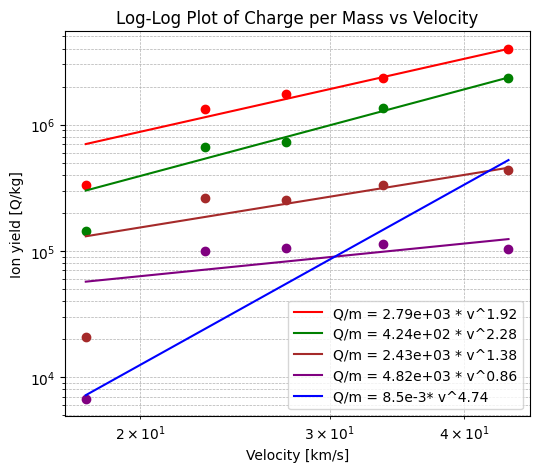

In [31]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data
velocity = np.array([17.8, 23.0, 27.3, 33.6, 44.0])  # km/s
# q_per_kg = np.array([71121.35, 271019.16, 419758.98, 748169.50, 1644371.72])  # Q/kg
q_per_kg_1 = np.array([3.30E+05,
1.32E+06,
1.75E+06,
2.36E+06,
3.95E+06])  # Q/kg
q_per_kg_2 = np.array([1.44E+05,
6.67E+05,
7.26E+05,
1.35E+06,
2.34E+06])  # Q/kg
q_per_kg_3 = np.array([2.08E+04,
2.64E+05,
2.54E+05,
3.31E+05,
4.34E+05])  # Q/kg
q_per_kg_4 = np.array([6.72E+03,
9.95E+04,
1.05E+05,
1.13E+05,
1.04E+05])  # Q/kg




# Define the power-law function (Q = c * v^beta)
def power_law(v, c, beta):
    return c * v ** beta

# Fit the data
popt, pcov = curve_fit(power_law, velocity, q_per_kg_1)
c_1, beta_1 = popt
# Print fitting results
print(f"Fitted parameters: c = {c_1:.2e}, beta = {beta_1:.2f}")
popt, pcov = curve_fit(power_law, velocity, q_per_kg_2)
c_2, beta_2 = popt
# Print fitting results
print(f"Fitted parameters: c = {c_2:.2e}, beta = {beta_2:.2f}")
popt, pcov = curve_fit(power_law, velocity, q_per_kg_3)
c_3, beta_3 = popt
# Print fitting results
print(f"Fitted parameters: c = {c_3:.2e}, beta = {beta_3:.2f}")
popt, pcov = curve_fit(power_law, velocity, q_per_kg_4)
c_4, beta_4 = popt
# Print fitting results
print(f"Fitted parameters: c = {c_4:.2e}, beta = {beta_4:.2f}")

# Generate data for plotting the fit curve
v_fit = np.linspace(min(velocity), max(velocity), 100)
q_fit_1 = power_law(v_fit, c_1, beta_1)
q_fit_2 = power_law(v_fit, c_2, beta_2)
q_fit_3 = power_law(v_fit, c_3, beta_3)
q_fit_4 = power_law(v_fit, c_4, beta_4)
q_fit_0= power_law(v_fit, 8.5e-3,4.74)

# Plot the data and the fit on a log-log scale
plt.figure(figsize=(6, 5))
plt.loglog(velocity, q_per_kg_1, 'o', color="red")  # Log-log scatter plot
plt.loglog(velocity, q_per_kg_2, 'o', color="green")  # Log-log scatter plot
plt.loglog(velocity, q_per_kg_3, 'o', color="brown")  # Log-log scatter plot
plt.loglog(velocity, q_per_kg_4, 'o', color="purple")  # Log-log scatter plot
plt.loglog(v_fit, q_fit_1, label=f"Q/m = {c_1:.2e} * v^{beta_1:.2f}", color="red")  # Log-log fit curve
plt.loglog(v_fit, q_fit_2, label=f"Q/m = {c_2:.2e} * v^{beta_2:.2f}", color="green")  # Log-log fit curve
plt.loglog(v_fit, q_fit_3, label=f"Q/m = {c_3:.2e} * v^{beta_3:.2f}", color="brown")  # Log-log fit curve
plt.loglog(v_fit, q_fit_4, label=f"Q/m = {c_4:.2e} * v^{beta_4:.2f}", color="purple")  # Log-log fit curve
plt.loglog(v_fit, q_fit_0, label=f"Q/m = 8.5e-3* v^4.74", color="blue")  # Log-log fit curve
plt.xlabel("Velocity [km/s]")
plt.ylabel("Ion yield [Q/kg]")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.title("Log-Log Plot of Charge per Mass vs Velocity")
plt.show()


In [7]:
import numpy as np
from scipy.optimize import curve_fit

# 実験データ
Q = np.array([9.75E-13, 6.06E-13, 4.43E-13, 2.64E-13])
m = np.array([3.69E-18, 2.38E-18, 1.34E-18, 6.08E-19])
v = np.array([23.0, 27.3, 33.6, 44.0])

# フィッティング関数
def model_func(vars, c, a, b):
    m, v = vars
    return c * m**a * v**b

# フィッティング
initial_guess = [8.5e-3, 1.0, 4.74]  # 実験値に近い初期値
params, covariance = curve_fit(
    model_func, (m, v), Q, p0=initial_guess, maxfev=10000, bounds=([1e-5, 0, 0], [1e-1, 2, 10])
)

# 結果の出力
c, a, b = params
print(f"c = {c:.4e}, a = {a:.4f}, b = {b:.4f}")


c = 8.5000e-03, a = 1.0000, b = 4.7400


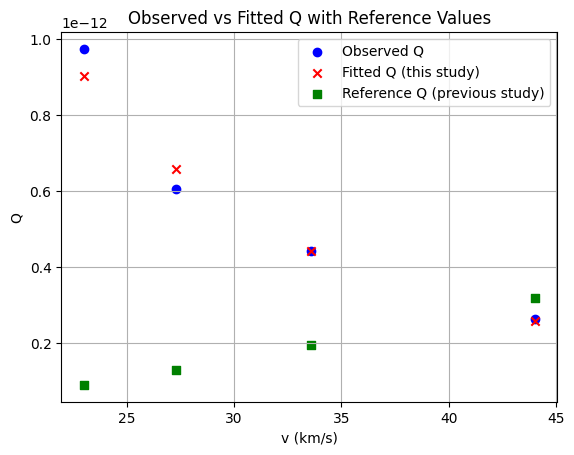

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 実験データ
Q = np.array([9.75E-13, 6.06E-13, 4.43E-13, 2.64E-13])
m = np.array([3.69E-18, 2.38E-18, 1.34E-18, 6.08E-19])
v = np.array([23.0, 27.3, 33.6, 44.0])

# コスト関数を定義（相対誤差）
def cost_function(params, m, v, Q):
    c, a, b = params
    Q_pred = c * m**a * v**b
    return np.sum(((Q - Q_pred) / Q)**2)  # 相対誤差の二乗を合計

# 最適化
initial_guess = [8.5e-3, 1.0, 4.74]
result = minimize(cost_function, initial_guess, args=(m, v, Q), method='Nelder-Mead')
c_fit, a_fit, b_fit = result.x

# フィッティング結果で Q を計算
Q_fit = c_fit * m**a_fit * v**b_fit

# 先行研究の結果で Q を計算
c_ref, a_ref, b_ref = 8.5e-3, 1.0, 4.74
Q_ref = c_ref * m**a_ref * v**b_ref

# グラフをプロット
plt.scatter(v, Q, label='Observed Q', color='blue')        # 観測値
plt.scatter(v, Q_fit, label='Fitted Q (this study)', color='red', marker='x')  # フィッティング値
plt.scatter(v, Q_ref, label='Reference Q (previous study)', color='green', marker='s')  # 先行研究値

# グラフの装飾
plt.legend()
plt.xlabel('v (km/s)')
plt.ylabel('Q')
plt.title('Observed vs Fitted Q with Reference Values')
plt.grid(True)
plt.show()
